# IceCube Event Classification with Machine Learning
**Author:** Josue Elizalde 
**Date:** April 2024

This notebook reproduces the analysis presented in the report _"Data Analysis with IceCube Monte Carlo Simulation Data"_, submitted for the Advanced Laboratory Course in Particle Physics at TU Dortmund.

The goal is to classify neutrino events (signal) from background (muons) using multivariate machine learning techniques.  
We compare three classifiers: Naive Bayes, k-Nearest Neighbors, and Random Forest.  
We use 10-fold cross-validation and evaluate models using accuracy, precision, recall, ROC curves and fβ-score.

## Part 1: Setup y Preprocesamiento

In [41]:
# Import standard libraries for machine learning and metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    f1_score, accuracy_score, confusion_matrix,
    roc_curve, roc_auc_score, precision_recall_curve, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Aesthetics for plots
plt.rcParams.update({
    'legend.frameon': False,
    'legend.fontsize': 'xx-large',
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 16,
    'lines.linewidth': 2.5,
    'figure.figsize': (8, 6)
})


In [42]:
# Load datasets: background, signal, and test samples
data_background_train = pd.read_csv("background_train.csv")
data_signal_train = pd.read_csv("signal_train.csv")
data_test = pd.read_csv("test.csv")

print(f"Background data shape: {data_background_train.shape}")
print(f"Signal data shape: {data_signal_train.shape}")
print(f"Test data shape: {data_test.shape}")


Background data shape: (18067, 283)
Signal data shape: (17933, 283)
Test data shape: (4000, 282)


In [43]:
# Combine signal and background into a single training set
data_train = pd.concat([data_background_train, data_signal_train], ignore_index=True)
print(f"Training data shape before removing MC/ID columns: {data_train.shape}")

# Remove Monte Carlo truth info and IDs based on column name patterns
columns_to_remove = [col for col in data_train.columns if any(keyword in col for keyword in ['Weight', 'MC', 'Corsika', 'ID', 'I3EventHeader'])]
data_train.drop(columns=columns_to_remove, inplace=True)
print(f"Training data shape after removal: {data_train.shape}")


Training data shape before removing MC/ID columns: (36000, 283)
Training data shape after removal: (36000, 188)


In [44]:
# Fill missing values with 0
data_train.fillna(0, inplace=True)
missing_total = data_train.isnull().sum().sum()
print(f"Total missing values after filling: {missing_total}")

# Check for infinite values
inf_count = data_train.isin([np.inf, -np.inf]).sum().sum()
print(f"Total infinite values in dataset: {inf_count}")


Total missing values after filling: 0
Total infinite values in dataset: 0


In [45]:
# Define features and labels
X = data_train.drop(columns=["label"])
y = data_train["label"]
print(f"Final feature matrix shape: {X.shape}")


Final feature matrix shape: (36000, 187)


In [46]:
# mRMR feature selection
from mrmr import mrmr_classif
selected_features_mrmr = mrmr_classif(X=X, y=y, K=12)
print(f"Selected features (mRMR): {selected_features_mrmr}")


100%|██████████| 12/12 [00:02<00:00,  4.14it/s]

Selected features (mRMR): ['LineFit_TTParams.lf_vel_z', 'SplineMPEDirectHitsC.n_dir_strings', 'HitStatisticsValues.z_travel', 'SplineMPEFitParams.rlogl', 'SplineMPEDirectHitsA.dir_track_length', 'LineFit_TT.zenith', 'SplineMPEDirectHitsA.n_dir_strings', 'MuEXAngular4.zenith', 'MuEXAngular4_Sigma.value', 'MPEFitHighNoise.zenith', 'SplineMPEDirectHitsA.n_dir_doms', 'SplineMPE.zenith']


In [47]:
# Split dataset for training and testing using only selected features
X_train, X_test, y_train, y_test = train_test_split(
    X[selected_features_mrmr], y, test_size=0.3, random_state=666
)
X_test

,LineFit_TTParams.lf_vel_z,SplineMPEDirectHitsC.n_dir_strings,HitStatisticsValues.z_travel,SplineMPEFitParams.rlogl,SplineMPEDirectHitsA.dir_track_length,LineFit_TT.zenith,SplineMPEDirectHitsA.n_dir_strings,MuEXAngular4.zenith,MuEXAngular4_Sigma.value,MPEFitHighNoise.zenith,SplineMPEDirectHitsA.n_dir_doms,SplineMPE.zenith
34815,0.235144,12.0,141.641069,6.898577,305.264360,2.550934,4.0,2.522353,0.028761,2.557668,6.0,2.527573
17333,-0.024116,4.0,2.934536,8.043323,119.105011,1.489889,2.0,1.513642,0.031828,1.503009,4.0,1.513084
1097,0.121292,2.0,129.577398,9.808835,19.447071,2.094771,1.0,2.184277,0.042216,2.176625,2.0,2.178681
20332,0.240593,2.0,131.338974,9.075070,88.388554,2.703240,1.0,2.680226,0.202048,2.645256,3.0,2.620930
21400,0.149044,7.0,34.278412,6.918897,168.427658,2.351732,3.0,2.333015,0.039042,2.269187,5.0,2.294691
...,...,...,...,...,...,...,...,...,...,...,...,...
4815,-0.043398,4.0,-31.680951,9.735575,1.172870,1.424652,1.0,1.530862,0.232681,1.499710,2.0,1.501830
34044,0.001550,4.0,-14.875003,7.908272,248.311408,1.575941,3.0,1.544321,0.094747,1.570183,5.0,1.560647
12696,-0.003105,4.0,-4.805557,8.900262,41.897524,1.559816,2.0,1.542828,1.113790,1.601866,3.0,1.562960
5677,-0.050722,5.0,-29.854876,8.401491,0.000000,1.394314,1.0,1.531001,0.093469,1.229248,1.0,1.543542


# Part 2: Auxiliar functions for evaluation

In [48]:
def quality_parameters(cm):
    """
    Compute precision, recall, and F-beta score from a confusion matrix.
    
    Args:
        cm (array-like): Confusion matrix in the format:
                         [[TN, FP],
                          [FN, TP]]
    
    Returns:
        tuple: (precision, recall, f_beta) with beta = 0.1
    """
    beta = 0.1
    precision = cm[1][1] / (cm[1][1] + cm[0][1])
    recall = cm[1][1] / (cm[1][1] + cm[1][0])
    f_beta = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
    
    return precision, recall, f_beta


In [49]:
def fbeta_evolution(p, r):
    """
    Compute F-beta score given arrays of precision and recall.

    Args:
        p (array-like): Precision values
        r (array-like): Recall values

    Returns:
        array-like: Corresponding F-beta scores
    """
    beta = 0.1
    return (1 + beta**2) * (p * r) / ((beta**2 * p) + r)


In [50]:
def punto_fb(cm):
    """
    Compute the ROC point (FPR, TPR) from confusion matrix.

    Args:
        cm (array-like): Confusion matrix

    Returns:
        tuple: (false positive rate, true positive rate)
    """
    tpr = cm[1][1] / (cm[1][1] + cm[1][0])
    fpr = cm[0][1] / (cm[0][1] + cm[0][0])
    return fpr, tpr


# Part 3: Forward Feature Selection

In [51]:
def forward_selection(X_train, X_test, y_train, y_test, model):
    """
    Perform forward feature selection based on F1-score.
    
    Args:
        X_train (DataFrame): Training feature matrix
        X_test (DataFrame): Testing feature matrix
        y_train (Series): Training labels
        y_test (Series): Testing labels
        model (sklearn classifier): Classifier to evaluate
    
    Returns:
        list: Selected feature names in order of selection
    """
    selected = []
    remaining = list(X_train.columns)
    best_score = 0

    while remaining:
        scores = []
        for feature in remaining:
            candidate_features = selected + [feature]
            model.fit(X_train[candidate_features], y_train)
            y_pred = model.predict(X_test[candidate_features])
            score = f1_score(y_test, y_pred)
            scores.append((score, feature))
        
        scores.sort(reverse=True)
        top_score, top_feature = scores[0]

        if top_score <= best_score:
            break

        selected.append(top_feature)
        remaining.remove(top_feature)
        best_score = top_score
        print(f"Selected feature: {top_feature}, F1-score: {top_score:.4f}")
    
    return selected


# Part 4 Training and Evaluation

## Gaussian Naïve Bayes

[Naïve Bayes] Accuracy: 0.85


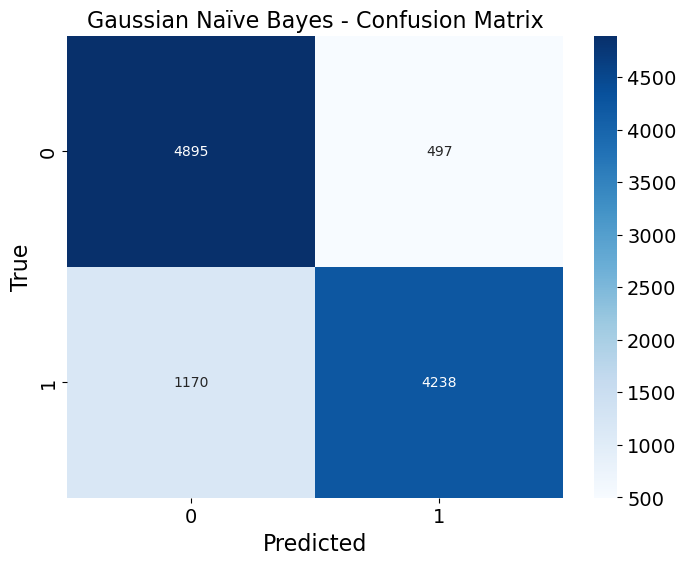

In [52]:
# Initialize Gaussian Naïve Bayes classifier
nb_classifier = GaussianNB()

# Train the classifier on the training set
nb_classifier.fit(X_train, y_train)

# Predict labels on the test set
y_pred = nb_classifier.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"[Naïve Bayes] Accuracy: {accuracy:.2f}")

# Compute confusion matrix
nb_cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure()
plt.title("Gaussian Naïve Bayes - Confusion Matrix")
sns.heatmap(nb_cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [53]:
# Print classification report
print("[Naïve Bayes] Classification Report:")
print(classification_report(y_test, y_pred))

# Compute quality metrics: precision, recall, and F-beta
nb_precision, nb_recall, nb_fbeta = quality_parameters(nb_cm)
print(f"[Naïve Bayes] Precision: {nb_precision:.2f}")
print(f"[Naïve Bayes] Recall: {nb_recall:.2f}")
print(f"[Naïve Bayes] F-beta: {nb_fbeta:.2f}")


[Naïve Bayes] Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.91      0.85      5392
           1       0.90      0.78      0.84      5408

    accuracy                           0.85     10800
   macro avg       0.85      0.85      0.85     10800
weighted avg       0.85      0.85      0.85     10800

[Naïve Bayes] Precision: 0.90
[Naïve Bayes] Recall: 0.78
[Naïve Bayes] F-beta: 0.89


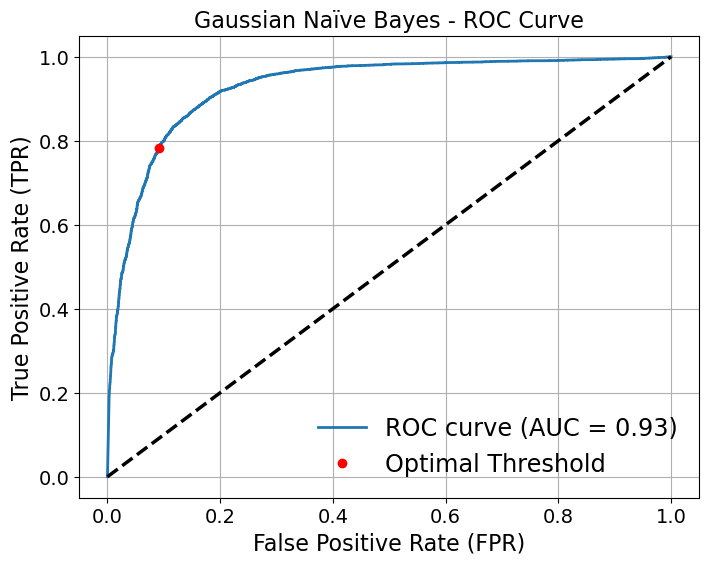

In [54]:
# Predict class probabilities for ROC curve
y_pred_proba = nb_classifier.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
nb_roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {nb_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='k')
x_opt, y_opt = punto_fb(nb_cm)
plt.plot(x_opt, y_opt, 'ro', lw=2, label='Optimal Threshold')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Gaussian Naïve Bayes - ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


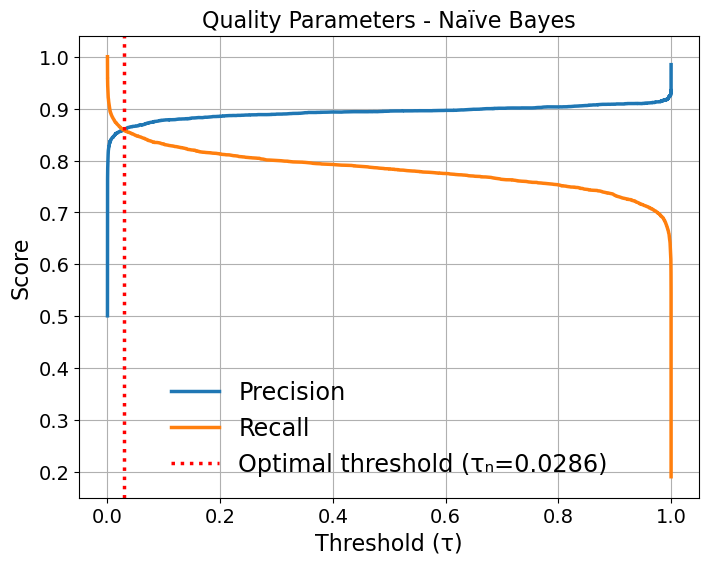

In [55]:
# Compute Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Plot Precision and Recall vs threshold
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")

# Compute optimal threshold as point where precision ≈ recall
opt_t = thresholds[np.argmin(np.abs(recall - precision))]
plt.axvline(x=opt_t, color='r', linestyle=':', label=f'Optimal threshold (τₙ={opt_t:.4f})')

plt.xlabel("Threshold (τ)")
plt.ylabel("Score")
plt.title("Quality Parameters - Naïve Bayes")
plt.legend()
plt.grid(True)
plt.show()


## Random Forest

[Random Forest] Accuracy: 0.94


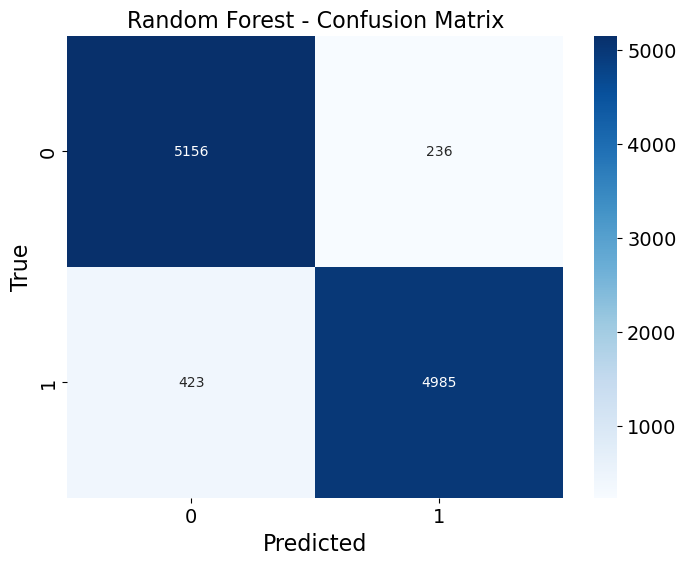

In [56]:
# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=666)

# Train the classifier on the training set
rf_classifier.fit(X_train, y_train)

# Predict labels on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"[Random Forest] Accuracy: {accuracy:.2f}")

# Compute confusion matrix
rf_cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure()
plt.title("Random Forest - Confusion Matrix")
sns.heatmap(rf_cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [57]:
# Print classification report
print("[Random Forest] Classification Report:")
print(classification_report(y_test, y_pred))

# Compute quality metrics: precision, recall, and F-beta
rf_precision, rf_recall, rf_fbeta = quality_parameters(rf_cm)
print(f"[Random Forest] Precision: {rf_precision:.2f}")
print(f"[Random Forest] Recall: {rf_recall:.2f}")
print(f"[Random Forest] F-beta: {rf_fbeta:.2f}")


[Random Forest] Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      5392
           1       0.95      0.92      0.94      5408

    accuracy                           0.94     10800
   macro avg       0.94      0.94      0.94     10800
weighted avg       0.94      0.94      0.94     10800

[Random Forest] Precision: 0.95
[Random Forest] Recall: 0.92
[Random Forest] F-beta: 0.95


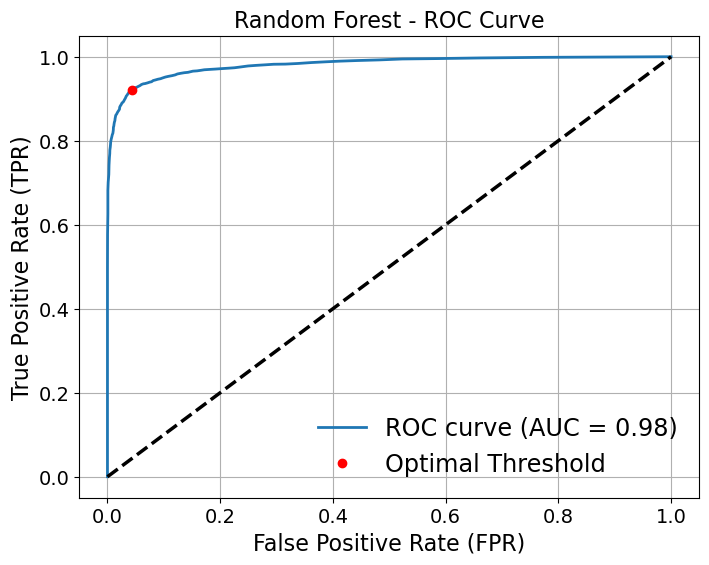

In [58]:
# Predict class probabilities for ROC curve
y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
rf_roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {rf_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='k')
x_opt, y_opt = punto_fb(rf_cm)
plt.plot(x_opt, y_opt, 'ro', lw=2, label='Optimal Threshold')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Random Forest - ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


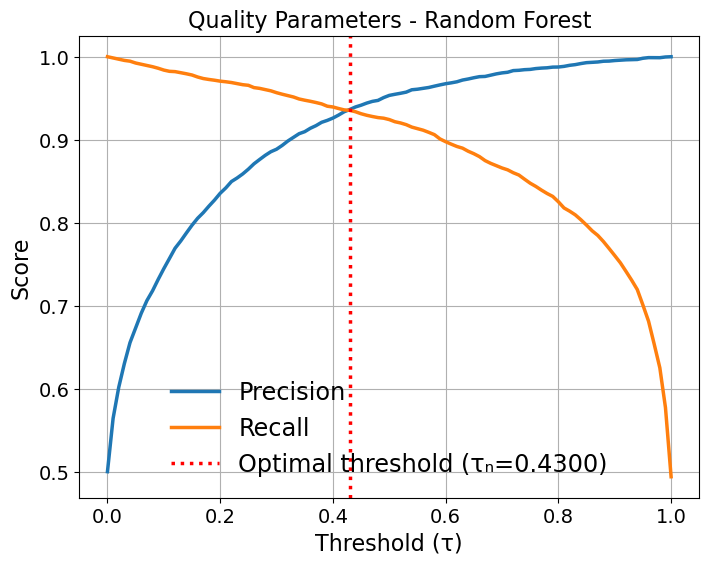

In [59]:
# Compute Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Find optimal threshold (where precision ≈ recall)
opt_t = thresholds[np.argmin(np.abs(recall - precision))]

# Plot Precision and Recall as function of threshold
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.axvline(x=opt_t, color='r', linestyle=':', label=f'Optimal threshold (τₙ={opt_t:.4f})')

plt.xlabel("Threshold (τ)")
plt.ylabel("Score")
plt.title("Quality Parameters - Random Forest")
plt.legend()
plt.grid(True)
plt.show()


## k-Nearest Neighbors (kNN)

[kNN] Accuracy: 0.87


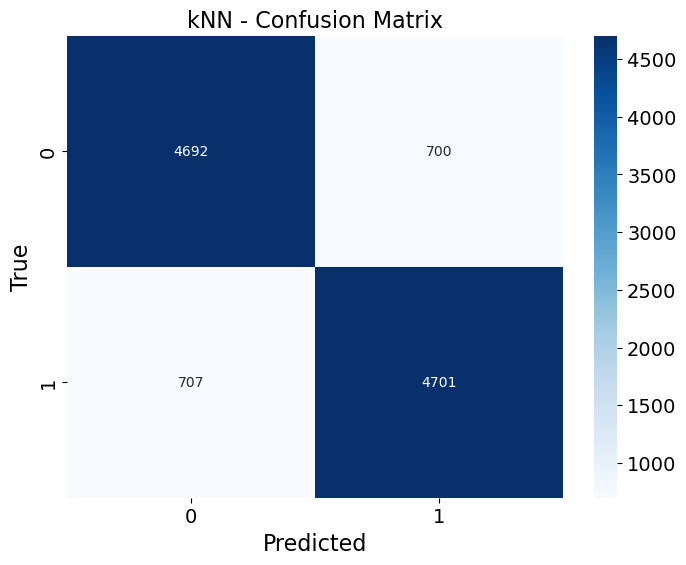

In [60]:
# Initialize k-Nearest Neighbors classifier
knn_classifier = KNeighborsClassifier(n_neighbors=3)

# Train the classifier
knn_classifier.fit(X_train, y_train)

# Predict labels on the test set
y_pred = knn_classifier.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"[kNN] Accuracy: {accuracy:.2f}")

# Compute confusion matrix
knn_cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure()
plt.title("kNN - Confusion Matrix")
sns.heatmap(knn_cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [61]:
# Print classification report
print("[kNN] Classification Report:")
print(classification_report(y_test, y_pred))

# Compute quality metrics
knn_precision, knn_recall, knn_fbeta = quality_parameters(knn_cm)
print(f"[kNN] Precision: {knn_precision:.2f}")
print(f"[kNN] Recall: {knn_recall:.2f}")
print(f"[kNN] F-beta: {knn_fbeta:.2f}")


[kNN] Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      5392
           1       0.87      0.87      0.87      5408

    accuracy                           0.87     10800
   macro avg       0.87      0.87      0.87     10800
weighted avg       0.87      0.87      0.87     10800

[kNN] Precision: 0.87
[kNN] Recall: 0.87
[kNN] F-beta: 0.87


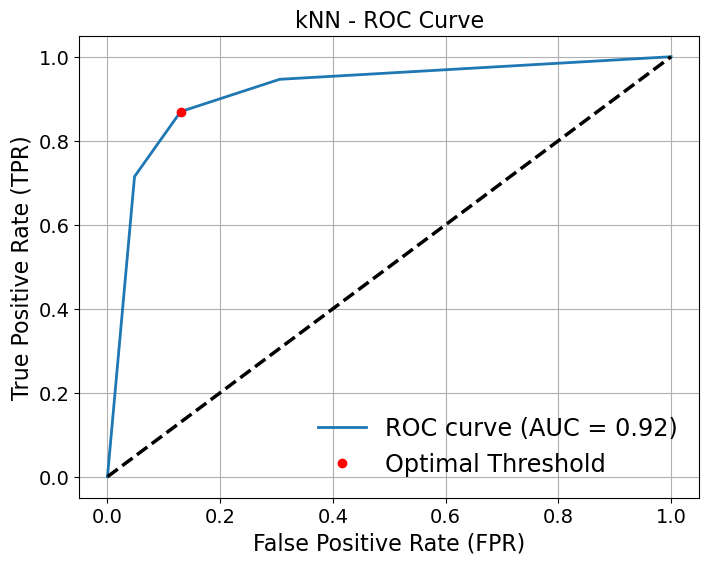

In [62]:
# Predict probabilities for class 1
y_pred_proba = knn_classifier.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
knn_roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {knn_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='k')
x_opt, y_opt = punto_fb(knn_cm)
plt.plot(x_opt, y_opt, 'ro', lw=2, label='Optimal Threshold')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('kNN - ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


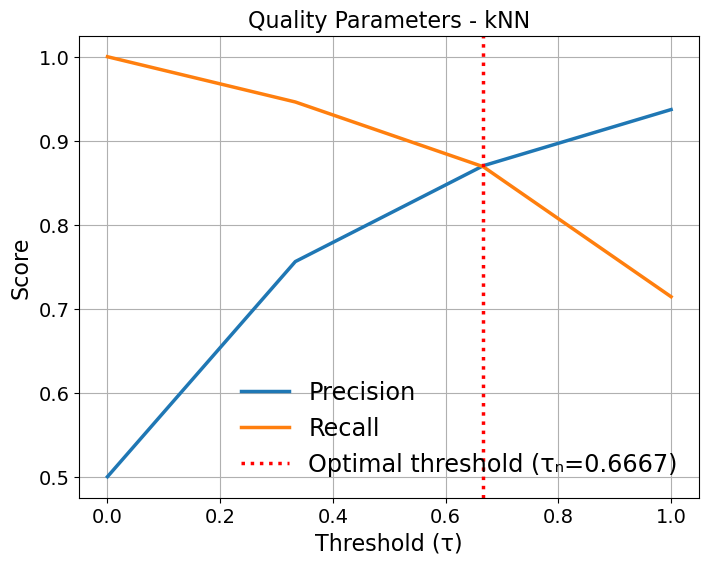

In [63]:
# Compute Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Determine optimal threshold (where precision ≈ recall)
opt_t = thresholds[np.argmin(np.abs(recall - precision))]

# Plot Precision and Recall vs threshold
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.axvline(x=opt_t, color='r', linestyle=':', label=f'Optimal threshold (τₙ={opt_t:.4f})')

plt.xlabel("Threshold (τ)")
plt.ylabel("Score")
plt.title("Quality Parameters - kNN")
plt.legend()
plt.grid(True)
plt.show()


# Part 5: Cross-Validation

In [66]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer

# Define number of folds for K-Fold Cross-Validation
k = 100  # 2000 was likely excessive and computationally expensive
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Choose the model to evaluate
model = GaussianNB()

# Compute standard cross-validated scores
accuracy_scores  = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')
precision_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='precision')
recall_scores    = cross_val_score(model, X_train, y_train, cv=kf, scoring='recall')
roc_auc_scores   = cross_val_score(model, X_train, y_train, cv=kf, scoring='roc_auc')


In [67]:
# Compute F-beta scores with beta = 0.1
f_beta_scores = fbeta_evolution(precision_scores, recall_scores)

# Compute Standard Error of the Mean (SEM) for each metric
def sem(scores):
    return np.std(scores) / np.sqrt(len(scores))

# Print average and SEM for all metrics
print("[Cross-Validation Results]")
print(f"Average Accuracy:     {accuracy_scores.mean():.4f} ± {sem(accuracy_scores):.4f}")
print(f"Average Precision:    {precision_scores.mean():.4f} ± {sem(precision_scores):.4f}")
print(f"Average Recall:       {recall_scores.mean():.4f} ± {sem(recall_scores):.4f}")
print(f"Average ROC AUC:      {roc_auc_scores.mean():.4f} ± {sem(roc_auc_scores):.4f}")
print(f"Average F-beta (β=0.1): {f_beta_scores.mean():.4f} ± {sem(f_beta_scores):.4f}")


[Cross-Validation Results]
Average Accuracy:     0.8433 ± 0.0023
Average Precision:    0.8898 ± 0.0032
Average Recall:       0.7818 ± 0.0037
Average ROC AUC:      0.9251 ± 0.0018
Average F-beta (β=0.1): 0.8886 ± 0.0032
